In [99]:
# This notebook aims to build the Barra Model under the circumstances of Chinese Stock Market:
# First, I generate several classic factors: Earnings-to-price, Enterprise-multiples.
# Seconds, I employ factor matrices to yield the factor return matrix through cross-sectional regression.
# Last, by using three funds' performance as example, I test their exposures on the constructed factor return matrix,
# on a time-series basis.

In [100]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.font_manager import FontProperties # get FontProperties

## Read data

### Read Balance sheet, Income Statement

In [101]:
# Income Statement
df_is = pd.read_table('./FS_Comins.txt',sep='\t')
df_is['Accper'] = pd.to_datetime(df_is['Accper'])
df_is = df_is[df_is['Typrep']=='A']

# Balance Sheet
df_bs = pd.read_table('./FS_Combas.txt',sep='\t')
df_bs['Accper'] = pd.to_datetime(df_bs['Accper'])
df_bs = df_bs[df_bs['Typrep']=='A']


In [102]:
# Filter seasonal data from 2019 - 2023
# One major issue: 
# As 'declare date' is later than 'Accper'
# and 'declare date' is largely missing value at a rate of～50%, use 'Accper' as replacement
dts = pd.date_range('2018-01-01', '2023-12-31', freq='Q')
df_is = df_is.sort_values(by=['Stkcd','Accper'])
df_is = df_is.drop(df_is[df_is['Accper'].isin(dts)==False].index)

df_bs = df_bs.sort_values(by=['Stkcd','Accper'])
df_bs = df_bs.drop(df_bs[df_bs['Accper'].isin(dts)==False].index)

df_bs

,Stkcd,ShortName,Accper,Typrep,IfCorrect,DeclareDate,A001101000,A0d1101101,A0d1102000,A0d1102101,...,A003105000,A003106000,A003107000,A0F3108000,A0F3109000,A003111000,A003100000,A003200000,A003000000,A004000000
1,1,平安银行,2018-03-31,A,0,NaN,NaN,NaN,NaN,NaN,...,8.044500e+10,NaN,NaN,NaN,NaN,2.500000e+07,2.233910e+11,NaN,2.233910e+11,3.338572e+12
2,1,平安银行,2018-06-30,A,0,NaN,NaN,NaN,NaN,NaN,...,8.488900e+10,NaN,NaN,NaN,NaN,3.310000e+08,2.281410e+11,NaN,2.281410e+11,3.367399e+12
3,1,平安银行,2018-09-30,A,0,NaN,NaN,NaN,NaN,NaN,...,9.197300e+10,NaN,NaN,NaN,NaN,3.370000e+08,2.352310e+11,NaN,2.352310e+11,3.352056e+12
4,1,平安银行,2018-12-31,A,1,2019-03-07,NaN,NaN,NaN,NaN,...,9.503700e+10,NaN,NaN,NaN,NaN,7.860000e+08,2.400420e+11,NaN,2.400420e+11,3.418592e+12
6,1,平安银行,2019-03-31,A,0,NaN,NaN,NaN,NaN,NaN,...,1.016090e+11,NaN,NaN,NaN,NaN,1.385000e+09,2.509380e+11,NaN,2.509380e+11,3.530180e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216760,873593,鼎智科技,2022-06-30,A,0,NaN,1.451765e+08,NaN,NaN,NaN,...,7.346315e+07,NaN,NaN,NaN,NaN,2.181199e+05,2.391224e+08,NaN,2.391224e+08,3.253838e+08
216762,873593,鼎智科技,2022-09-30,A,0,NaN,1.273547e+08,NaN,NaN,NaN,...,8.593378e+07,NaN,NaN,NaN,NaN,5.341674e+05,2.519682e+08,NaN,2.519682e+08,3.476304e+08
216764,873593,鼎智科技,2022-12-31,A,0,NaN,8.307062e+07,NaN,NaN,NaN,...,9.216566e+07,NaN,NaN,NaN,NaN,4.125414e+05,2.684286e+08,NaN,2.684286e+08,3.661453e+08
216766,873593,鼎智科技,2023-03-31,A,0,NaN,1.008440e+08,NaN,NaN,NaN,...,1.298181e+08,NaN,NaN,NaN,NaN,3.184129e+05,3.061063e+08,NaN,3.061063e+08,4.119192e+08


In [103]:
# Income statement: cumulative data, so need to do difference and extract the base to get the 'change'
def get_year(x):
    return x.date().year
df_is.loc[:,'year'] = df_is['Accper'].apply(lambda x: get_year(x))

df_bs.loc[:,'year'] = df_bs['Accper'].apply(lambda x: get_year(x))
df_bs

,Stkcd,ShortName,Accper,Typrep,IfCorrect,DeclareDate,A001101000,A0d1101101,A0d1102000,A0d1102101,...,A003106000,A003107000,A0F3108000,A0F3109000,A003111000,A003100000,A003200000,A003000000,A004000000,year
1,1,平安银行,2018-03-31,A,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.500000e+07,2.233910e+11,NaN,2.233910e+11,3.338572e+12,2018
2,1,平安银行,2018-06-30,A,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.310000e+08,2.281410e+11,NaN,2.281410e+11,3.367399e+12,2018
3,1,平安银行,2018-09-30,A,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.370000e+08,2.352310e+11,NaN,2.352310e+11,3.352056e+12,2018
4,1,平安银行,2018-12-31,A,1,2019-03-07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.860000e+08,2.400420e+11,NaN,2.400420e+11,3.418592e+12,2018
6,1,平安银行,2019-03-31,A,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.385000e+09,2.509380e+11,NaN,2.509380e+11,3.530180e+12,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216760,873593,鼎智科技,2022-06-30,A,0,NaN,1.451765e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.181199e+05,2.391224e+08,NaN,2.391224e+08,3.253838e+08,2022
216762,873593,鼎智科技,2022-09-30,A,0,NaN,1.273547e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.341674e+05,2.519682e+08,NaN,2.519682e+08,3.476304e+08,2022
216764,873593,鼎智科技,2022-12-31,A,0,NaN,8.307062e+07,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.125414e+05,2.684286e+08,NaN,2.684286e+08,3.661453e+08,2022
216766,873593,鼎智科技,2023-03-31,A,0,NaN,1.008440e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.184129e+05,3.061063e+08,NaN,3.061063e+08,4.119192e+08,2023


In [104]:
col = 'B002000000' # Get Earning 
# Only need to change this line to get the column we want to analyze

a = df_is.copy(deep=True)[['Stkcd','ShortName','Accper','Typrep',col,'year']]
a.loc[:,col] = a.groupby(['Stkcd','year']).shift(1,fill_value=0) # shift one line after
a.loc[:,col] = df_is[col] - a[col]
# Rename 'Accper' to 'Trddt' for alignment
a.rename(columns={'Accper':'Trddt'}, inplace=True)
a = a.set_index(['Stkcd','Trddt'])
a = a.groupby([pd.Grouper(level='Stkcd'), pd.Grouper(level='Trddt', freq='Q')]).last()
a[0:40]

ShortName Typrep    B002000000  year
Stkcd Trddt                                          
1     2018-03-31      平安银行      A  6.595000e+09  2018
      2018-06-30      平安银行      A  6.777000e+09  2018
      2018-09-30      平安银行      A  7.084000e+09  2018
      2018-12-31      平安银行      A  4.362000e+09  2018
      2019-03-31      平安银行      A  7.446000e+09  2019
      2019-06-30      平安银行      A  7.957000e+09  2019
      2019-09-30      平安银行      A  8.218000e+09  2019
      2019-12-31      平安银行      A  4.574000e+09  2019
      2020-03-31      平安银行      A  8.548000e+09  2020
      2020-06-30      平安银行      A  5.130000e+09  2020
      2020-09-30      平安银行      A  8.720000e+09  2020
      2020-12-31      平安银行      A  6.530000e+09  2020
      2021-03-31      平安银行      A  1.013200e+10  2021
      2021-06-30      平安银行      A  7.451000e+09  2021
      2021-09-30      平安银行      A  1.155200e+10  2021
      2021-12-31      平安银行      A  7.201000e+09  2021
      2022-03-31      平安银行      A  1.285000e+10  2022
      2022-06-30      平安银行      A  9.238000e+09  2022
      2022-09-30      平安银行      A  1.457100e+10  2022
      2022-12-31      平安银行      A  8.857000e+09  2022
      2023-03-31      平安银行      A  1.460200e+10  2023
      2023-06-30      平安银行      A  1.078500e+10  2023
2     2018-03-31       万科A      A  1.779486e+09  2018
      2018-06-30       万科A      A  1.174311e+10  2018
      2018-09-30       万科A      A  8.275198e+09  2018
      2018-12-31       万科A      A  2.747450e+10  2018
      2019-03-31       万科A      A  3.205934e+09  2019
      2019-06-30       万科A      A  1.607974e+10  2019
      2019-09-30       万科A      A  9.304740e+09  2019
      2019-12-31       万科A      A  2.654120e+10  2019
      2020-03-31       万科A      A  2.430275e+09  2020
      2020-06-30       万科A      A  1.619892e+10  2020
      2020-09-30       万科A      A  1.144235e+10  2020
      2020-12-31       万科A      A  2.922657e+10  2020
      2021-03-31       万科A      A  2.507051e+09  2021
      2021-06-30       万科A      A  1.366647e+10  2021
      2021-09-30       万科A      A  8.430831e+09  2021
      2021-12-31       万科A      A  1.346518e+10  2021
      2022-03-31       万科A      A  2.786996e+09  2022
      2022-06-30       万科A      A  1.531574e+10  2022

In [105]:
col = 'B001000000' # Get EBIT 
# Only need to change this line to get the column we want to analyze

ebit = df_is.copy(deep=True)[['Stkcd','ShortName','Accper','Typrep',col,'year']]
ebit.loc[:,col] = ebit.groupby(['Stkcd','year']).shift(1,fill_value=0) # 数值shift after
ebit.loc[:,col] = df_is[col] - ebit[col]
ebit.rename(columns={'Accper':'Trddt'}, inplace=True)
ebit = ebit.set_index(['Stkcd','Trddt'])
ebit = ebit.groupby([pd.Grouper(level='Stkcd'), pd.Grouper(level='Trddt', freq='Q')]).last()
ebit[0:40]

ShortName Typrep    B001000000  year
Stkcd Trddt                                          
1     2018-03-31      平安银行      A  8.567000e+09  2018
      2018-06-30      平安银行      A  8.800000e+09  2018
      2018-09-30      平安银行      A  9.199000e+09  2018
      2018-12-31      平安银行      A  5.665000e+09  2018
      2019-03-31      平安银行      A  9.671000e+09  2019
      2019-06-30      平安银行      A  1.033200e+10  2019
      2019-09-30      平安银行      A  1.067300e+10  2019
      2019-12-31      平安银行      A  5.564000e+09  2019
      2020-03-31      平安银行      A  1.095800e+10  2020
      2020-06-30      平安银行      A  6.629000e+09  2020
      2020-09-30      平安银行      A  1.123900e+10  2020
      2020-12-31      平安银行      A  7.928000e+09  2020
      2021-03-31      平安银行      A  1.287400e+10  2021
      2021-06-30      平安银行      A  9.467000e+09  2021
      2021-09-30      平安银行      A  1.444600e+10  2021
      2021-12-31      平安银行      A  9.092000e+09  2021
      2022-03-31      平安银行      A  1.618400e+10  2022
      2022-06-30      平安银行      A  1.159900e+10  2022
      2022-09-30      平安银行      A  1.832900e+10  2022
      2022-12-31      平安银行      A  1.114100e+10  2022
      2023-03-31      平安银行      A  1.836700e+10  2023
      2023-06-30      平安银行      A  1.356600e+10  2023
2     2018-03-31       万科A      A  2.999302e+09  2018
      2018-06-30       万科A      A  1.666854e+10  2018
      2018-09-30       万科A      A  1.199426e+10  2018
      2018-12-31       万科A      A  3.579809e+10  2018
      2019-03-31       万科A      A  5.871700e+09  2019
      2019-06-30       万科A      A  2.185428e+10  2019
      2019-09-30       万科A      A  1.409881e+10  2019
      2019-12-31       万科A      A  3.471450e+10  2019
      2020-03-31       万科A      A  4.795679e+09  2020
      2020-06-30       万科A      A  2.165477e+10  2020
      2020-09-30       万科A      A  1.538755e+10  2020
      2020-12-31       万科A      A  3.783776e+10  2020
      2021-03-31       万科A      A  4.108071e+09  2021
      2021-06-30       万科A      A  1.797280e+10  2021
      2021-09-30       万科A      A  1.102043e+10  2021
      2021-12-31       万科A      A  1.912133e+10  2021
      2022-03-31       万科A      A  4.081142e+09  2022
      2022-06-30       万科A      A  2.027806e+10  2022

In [106]:
col = 'A002000000' # Total debt
debt = df_bs.copy(deep=True)[['Stkcd','ShortName','Accper','Typrep',col,'year']]
debt.loc[:,col] = debt.groupby(['Stkcd','year']).shift(1,fill_value=0) # 数值shift after
debt.loc[:,col] = df_bs[col] - debt[col]
debt.rename(columns={'Accper':'Trddt'}, inplace=True)
debt = debt.set_index(['Stkcd','Trddt'])
debt = debt.groupby([pd.Grouper(level='Stkcd'), pd.Grouper(level='Trddt', freq='Q')]).last()
debt[0:40]

ShortName Typrep    A002000000  year
Stkcd Trddt                                          
1     2018-03-31      平安银行      A  3.115181e+12  2018
      2018-06-30      平安银行      A  2.407700e+10  2018
      2018-09-30      平安银行      A -2.243300e+10  2018
      2018-12-31      平安银行      A  6.172500e+10  2018
      2019-03-31      平安银行      A  3.279242e+12  2019
      2019-06-30      平安银行      A  5.492100e+10  2019
      2019-09-30      平安银行      A  8.544700e+10  2019
      2019-12-31      平安银行      A  2.064770e+11  2019
      2020-03-31      平安银行      A  3.779943e+12  2020
      2020-06-30      平安银行      A  4.728200e+10  2020
      2020-09-30      平安银行      A  1.609250e+11  2020
      2020-12-31      平安银行      A  1.162330e+11  2020
      2021-03-31      平安银行      A  4.200357e+12  2021
      2021-06-30      平安银行      A  1.459700e+11  2021
      2021-09-30      平安银行      A  1.178890e+11  2021
      2021-12-31      平安银行      A  6.171600e+10  2021
      2022-03-31      平安银行      A  4.711774e+12  2022
      2022-06-30      平安银行      A -1.509600e+10  2022
      2022-09-30      平安银行      A  7.307100e+10  2022
      2022-12-31      平安银行      A  1.170850e+11  2022
      2023-03-31      平安银行      A  5.009152e+12  2023
      2023-06-30      平安银行      A  3.929900e+10  2023
2     2018-03-31       万科A      A  1.028927e+12  2018
      2018-06-30       万科A      A  1.104401e+11  2018
      2018-09-30       万科A      A  7.696281e+10  2018
      2018-12-31       万科A      A  7.662833e+10  2018
      2019-03-31       万科A      A  1.314977e+12  2019
      2019-06-30       万科A      A  2.961233e+10  2019
      2019-09-30       万科A      A  4.932195e+10  2019
      2019-12-31       万科A      A  6.543901e+10  2019
      2020-03-31       万科A      A  1.465684e+12  2020
      2020-06-30       万科A      A  4.924684e+10  2020
      2020-09-30       万科A      A -3.107177e+09  2020
      2020-12-31       万科A      A  7.509291e+09  2020
      2021-03-31       万科A      A  1.552428e+12  2021
      2021-06-30       万科A      A  3.889683e+10  2021
      2021-09-30       万科A      A  1.147251e+09  2021
      2021-12-31       万科A      A -4.660722e+10  2021
      2022-03-31       万科A      A  1.554060e+12  2022
      2022-06-30       万科A      A -6.656598e+10  2022

In [107]:
col = 'A001101000' # get Cash
cash = df_bs.copy(deep=True)[['Stkcd','ShortName','Accper','Typrep',col,'year']]
cash.loc[:,col] = cash.groupby(['Stkcd','year']).shift(1,fill_value=0) # 数值shift after
cash.loc[:,col] = df_bs[col] - cash[col]
cash.rename(columns={'Accper':'Trddt'}, inplace=True)
cash = cash.set_index(['Stkcd','Trddt'])
cash = cash.groupby([pd.Grouper(level='Stkcd'), pd.Grouper(level='Trddt', freq='Q')]).last()
cash[0:40]

ShortName Typrep    A001101000  year
Stkcd Trddt                                          
1     2018-03-31      平安银行      A           NaN  2018
      2018-06-30      平安银行      A           NaN  2018
      2018-09-30      平安银行      A           NaN  2018
      2018-12-31      平安银行      A           NaN  2018
      2019-03-31      平安银行      A           NaN  2019
      2019-06-30      平安银行      A           NaN  2019
      2019-09-30      平安银行      A           NaN  2019
      2019-12-31      平安银行      A           NaN  2019
      2020-03-31      平安银行      A           NaN  2020
      2020-06-30      平安银行      A           NaN  2020
      2020-09-30      平安银行      A           NaN  2020
      2020-12-31      平安银行      A           NaN  2020
      2021-03-31      平安银行      A           NaN  2021
      2021-06-30      平安银行      A           NaN  2021
      2021-09-30      平安银行      A           NaN  2021
      2021-12-31      平安银行      A           NaN  2021
      2022-03-31      平安银行      A           NaN  2022
      2022-06-30      平安银行      A           NaN  2022
      2022-09-30      平安银行      A           NaN  2022
      2022-12-31      平安银行      A           NaN  2022
      2023-03-31      平安银行      A           NaN  2023
      2023-06-30      平安银行      A           NaN  2023
2     2018-03-31       万科A      A  9.478231e+10  2018
      2018-06-30       万科A      A  6.476974e+10  2018
      2018-09-30       万科A      A -2.678653e+10  2018
      2018-12-31       万科A      A  5.565192e+10  2018
      2019-03-31       万科A      A  1.432204e+11  2019
      2019-06-30       万科A      A  6.484092e+08  2019
      2019-09-30       万科A      A -3.662858e+10  2019
      2019-12-31       万科A      A  5.895435e+10  2019
      2020-03-31       万科A      A  1.732716e+11  2020
      2020-06-30       万科A      A  2.101986e+10  2020
      2020-09-30       万科A      A -2.124143e+10  2020
      2020-12-31       万科A      A  2.218069e+10  2020
      2021-03-31       万科A      A  1.965986e+11  2021
      2021-06-30       万科A      A -1.382596e+09  2021
      2021-09-30       万科A      A -4.810900e+10  2021
      2021-12-31       万科A      A  2.245403e+09  2021
      2022-03-31       万科A      A  1.417833e+11  2022
      2022-06-30       万科A      A -7.102413e+08  2022

### Read Stock data (Price, Volume etc.)

In [108]:
df = pd.read_table('./TRD_Dalyr.txt',sep='\t')
df1 = pd.read_table('./TRD_Dalyr1.txt', sep='\t')
df2 = pd.read_table('./TRD_Dalyr2.txt', sep='\t')
df3 = pd.read_table('./TRD_Dalyr3.txt', sep='\t')
df4 = pd.read_table('./TRD_Dalyr4.txt', sep='\t')
# 将Combine 4 dataframes and convert Trddt to datetime
df = pd.concat([df,df1,df2,df3,df4])
df['Trddt'] = pd.to_datetime(df['Trddt'])
df = df.set_index(['Stkcd','Trddt'])

In [109]:
df_copy = df.copy()
df_copy

Opnprc  Hiprc  Loprc  Clsprc   Dnshrtrd      Dnvaltrd   
Stkcd  Trddt                                                               
1      2019-01-02    9.39   9.42   9.16    9.19   53938632  4.986951e+08  \
       2019-01-03    9.18   9.33   9.15    9.28   41553795  3.844577e+08   
       2019-01-04    9.24   9.82   9.22    9.75  148115906  1.422150e+09   
       2019-01-07    9.84   9.85   9.63    9.74   86568766  8.411664e+08   
       2019-01-08    9.73   9.74   9.62    9.66   40238811  3.892478e+08   
...                   ...    ...    ...     ...        ...           ...   
873593 2023-08-25   77.00  78.00  71.01   71.01     869133  6.438685e+07   
       2023-08-28   74.51  75.88  67.25   67.26    1459826  1.029311e+08   
       2023-08-29   67.50  79.95  67.50   79.80    2763524  2.073681e+08   
       2023-08-30   78.01  83.78  75.00   76.25    2002633  1.582196e+08   
       2023-08-31   75.95  78.50  74.44   77.50    1007999  7.730596e+07   

                        Dsmvosd       Dsmvtll    Dretwd    Dretnd   
Stkcd  Trddt                                                        
1      2019-01-02  1.577946e+08  1.577961e+08 -0.020256 -0.020256  \
       2019-01-03  1.593399e+08  1.593414e+08  0.009793  0.009793   
       2019-01-04  1.674099e+08  1.674115e+08  0.050647  0.050647   
       2019-01-07  1.672382e+08  1.672398e+08 -0.001026 -0.001026   
       2019-01-08  1.658646e+08  1.658662e+08 -0.008214 -0.008214   
...                         ...           ...       ...       ...   
873593 2023-08-25  1.275713e+06  3.410045e+06 -0.108922 -0.108922   
       2023-08-28  1.208343e+06  3.229962e+06 -0.052809 -0.052809   
       2023-08-29  1.433628e+06  3.832159e+06  0.186441  0.186441   
       2023-08-30  1.369851e+06  3.661680e+06 -0.044486 -0.044486   
       2023-08-31  1.392308e+06  3.721708e+06  0.016393  0.016393   

                      Adjprcwd    Adjprcnd  Markettype    Capchgdt  Trdsta   
Stkcd  Trddt                                                                 
1      2019-01-02   953.465954  761.264196           4  2018-05-21       1  \
       2019-01-03   962.803488  768.719449           4  2018-05-21       1   
       2019-01-04  1011.566165  807.652438           4  2018-05-21       1   
       2019-01-07  1010.528661  806.824077           4  2018-05-21       1   
       2019-01-08  1002.228631  800.197185           4  2018-05-21       1   
...                        ...         ...         ...         ...     ...   
873593 2023-08-25    71.010000   71.010000          64  2023-05-12       1   
       2023-08-28    67.260000   67.260000          64  2023-05-12       1   
       2023-08-29    79.800000   79.800000          64  2023-05-12       1   
       2023-08-30    76.250000   76.250000          64  2023-05-12       1   
       2023-08-31    77.500000   77.500000          64  2023-05-12       1   

                   Ahshrtrd_D  Ahvaltrd_D  PreClosePrice  ChangeRatio  
Stkcd  Trddt                                                           
1      2019-01-02         NaN         NaN           9.38    -0.020256  
       2019-01-03         NaN         NaN           9.19     0.009793  
       2019-01-04         NaN         NaN           9.28     0.050647  
       2019-01-07         NaN         NaN           9.75    -0.001026  
       2019-01-08         NaN         NaN           9.74    -0.008214  
...                       ...         ...            ...          ...  
873593 2023-08-25         0.0         0.0          79.69    -0.108922  
       2023-08-28         0.0         0.0          71.01    -0.052809  
       2023-08-29         0.0         0.0          67.26     0.186441  
       2023-08-30         0.0         0.0          79.80    -0.044486  
       2023-08-31         0.0         0.0          76.25     0.016393  

[4913348 rows x 19 columns]

In [110]:
# construct enterprice value
ev = df_copy['Dsmvtll'] + debt['A002000000'] - cash['A001101000']

## Factor construction: ETOP + EM

In [111]:
# B002000000 Earning -> ETOP
keys = a['B002000000'].rolling(window=4, min_periods=4).sum().keys()
factor_df = pd.DataFrame(index=keys)
factor_df.loc[:,'ETOP'] = a['B002000000'].rolling(window=4, min_periods=4).sum() / df_copy['Dsmvtll']
# B001000000 EBIT -> EM
keys_ebit = ebit['B001000000'].rolling(window=4, min_periods=4).sum().keys()
factor_df.loc[:,'EM'] = ebit['B001000000'].rolling(window=4, min_periods=4).sum() / ev
factor_df

ETOP        EM
Stkcd  Trddt                          
1      2018-03-31        NaN       NaN
       2018-06-30        NaN       NaN
       2018-09-30        NaN       NaN
       2018-12-31        NaN       NaN
       2019-03-31        NaN       NaN
...                      ...       ...
873593 2022-06-30        NaN       NaN
       2022-09-30        NaN       NaN
       2022-12-31        NaN       NaN
       2023-03-31        NaN       NaN
       2023-06-30  15.695507 -0.925352

[95556 rows x 2 columns]

In [112]:
pd.DataFrame(factor_df).to_csv('factors.csv')

Text(0.5, 1.0, 'Income statement time trend')

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


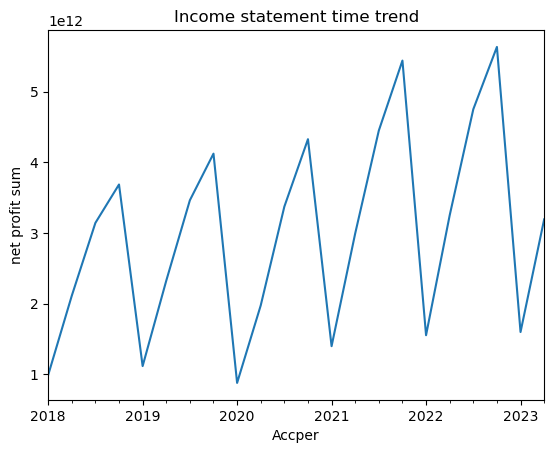

In [113]:
# plot trends to check
df_is.groupby('Accper')['B002000000'].sum().plot()
plt.ylabel('net profit sum')
plt.title("Income statement time trend")

Text(0.5, 1.0, 'Income statement time trend (by diff)')

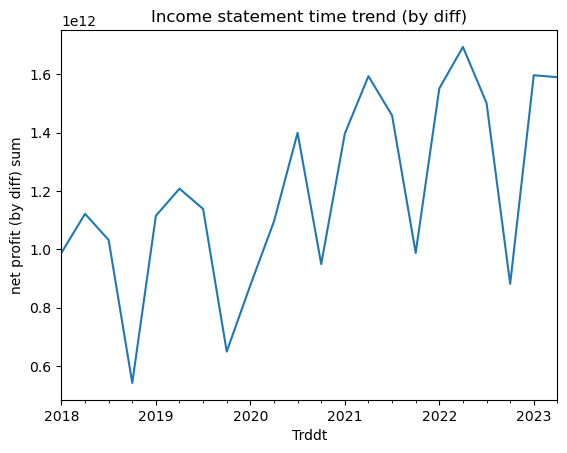

In [114]:
# plot trends to check
a.groupby('Trddt')['B002000000'].sum().plot()
plt.ylabel('net profit (by diff) sum')
plt.title("Income statement time trend (by diff)")

In [115]:
b = a.groupby('Trddt')['B002000000'].sum().rolling(window=4, min_periods=4).sum()
b

Trddt
2018-03-31             NaN
2018-06-30             NaN
2018-09-30             NaN
2018-12-31    3.683948e+12
2019-03-31    3.811137e+12
2019-06-30    3.897404e+12
2019-09-30    4.003827e+12
2019-12-31    4.111306e+12
2020-03-31    3.873239e+12
2020-06-30    3.760832e+12
2020-09-30    4.022134e+12
2020-12-31    4.322520e+12
2021-03-31    4.842508e+12
2021-06-30    5.340872e+12
2021-09-30    5.400186e+12
2021-12-31    5.438351e+12
2022-03-31    5.593240e+12
2022-06-30    5.693600e+12
2022-09-30    5.736272e+12
2022-12-31    5.630119e+12
2023-03-31    5.675484e+12
2023-06-30    5.571657e+12
Name: B002000000, dtype: float64

Text(0.5, 1.0, 'Income statement time trend\n (by diff + sum up rolling 4 seasons)')

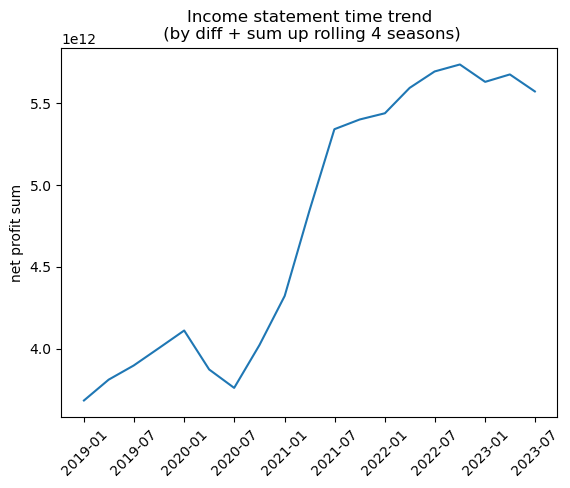

In [116]:
# plot trends to check
plt.plot(a.groupby('Trddt')['B002000000'].sum().rolling(window=4, min_periods=4).sum().keys(),a.groupby('Trddt')['B002000000'].sum().rolling(window=4, min_periods=4).sum())
plt.ylabel('net profit sum')
plt.xticks(rotation=45)
plt.title("Income statement time trend\n (by diff + sum up rolling 4 seasons)")

### Analyze a fund with the Barra model

In [117]:
! pip install jqdatasdk


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [118]:
# Import a specific database 'JoinQuant' in order to get data for funds
import jqdatasdk
from jqdatasdk import *
from jqdatasdk import finance
from sklearn import linear_model
auth('18500303988','Fanjr0224$')

In [119]:
# Exrtact data from JoinQuant online
myfund =get_price('502000.XSHG', start_date= '2019-01-01 09:00:00',end_date='2023-06-30 14:00:00',fq='post', 
                  frequency='daily', fields=['open','close','low','high','volume','money','avg','paused','factor'],round=False) 
myfund

,open,close,low,high,volume,money,avg,paused,factor
2019-01-02,0.529584,0.529584,0.529584,0.529584,0.000000e+00,0.0,0.529584,0.0,0.708000
2019-01-03,0.529584,0.529584,0.529584,0.529584,0.000000e+00,0.0,0.529584,1.0,0.708000
2019-01-04,0.533498,0.565404,0.518658,0.565404,6.620889e+04,35933.0,0.542699,0.0,0.742000
2019-01-07,0.565404,0.565404,0.565404,0.565404,0.000000e+00,0.0,0.565404,0.0,0.742000
2019-01-08,0.541660,0.549080,0.541660,0.549080,4.097035e+02,224.0,0.546706,0.0,0.742000
...,...,...,...,...,...,...,...,...,...
2023-06-26,1.101774,1.095458,1.094757,1.108792,6.813700e+05,750149.0,1.101072,0.0,0.701767
2023-06-27,1.103879,1.103178,1.098265,1.103879,6.615016e+04,72828.0,1.101072,0.0,0.701767
2023-06-28,1.103178,1.105985,1.096862,1.105985,9.347262e+04,102798.0,1.099669,0.0,0.701767
2023-06-29,1.097564,1.110195,1.097564,1.110897,3.564274e+05,394337.0,1.106687,0.0,0.701767


0.19828633462431436 0.16021156874296577 0.180439049158583


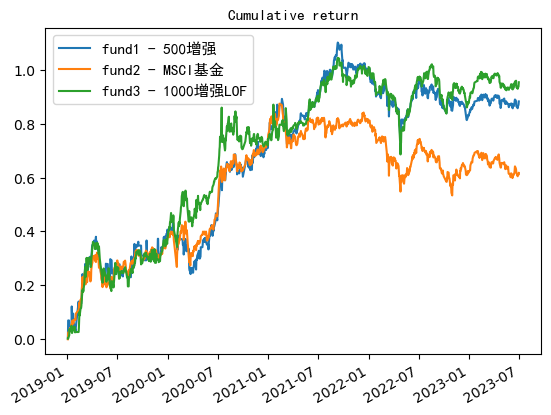

In [120]:
myfund =get_price('502000.XSHG', start_date= '2019-01-01 09:00:00',end_date='2023-06-30 14:00:00',fq='post', frequency='daily', fields=['open','close','low','high','volume','money',
        'avg','paused','factor'],round=False) 
myfund.close.pct_change().cumsum().plot(label='fund1 - 500增强')

myfund2 = get_price('512160.XSHG', start_date= '2019-01-01 09:00:00',end_date='2023-06-30 14:00:00',fq='post', frequency='daily', fields=['open','close','low','high','volume','money',
        'avg','paused','factor'],round=False) 
myfund2.close.pct_change().cumsum().plot(label='fund2 - MSCI基金')
myfund3 = get_price('161039.XSHE', start_date= '2019-01-01 09:00:00',end_date='2023-06-30 14:00:00',fq='post', frequency='daily', fields=['open','close','low','high','volume','money',
        'avg','paused','factor'],round=False) 
myfund3.close.pct_change().cumsum().plot(label='fund3 - 1000增强LOF')
font = FontProperties(fname="SimHei.ttf", size=11) 
plt.title('Cumulative return',font=font)
plt.legend(prop=font)
print(myfund3.close.pct_change().mean()/myfund3.close.pct_change().std()* np.sqrt(12),
      myfund2.close.pct_change().mean()/myfund2.close.pct_change().std()* np.sqrt(12),
      myfund.close.pct_change().mean()/myfund.close.pct_change().std()* np.sqrt(12))

In [121]:
# Read factor combined
factor_ret = pd.read_csv('params1.csv')
factor_ret = factor_ret.drop(columns='SEASON')
cols = list(factor_ret.columns)
cols[0] = 'Trddt'
factor_ret.columns = cols
factor_ret.loc[:,'Trddt'] = factor_ret['Trddt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
factor_ret

,Trddt,ATO,GP,GPM,ROA,DTOP,Beta,BTOP,VSAL,VERN,...,EGRO,SGRO,LNCAP,ETOP,EM,utils,realestate,conglomerates,industrials,commerce
0,2019-01-31 00:00:00,-0.423522,0.010286,3.229791e-02,-1.223407,-0.025155,0.220284,-0.285546,0.728066,-0.049934,...,-0.002111,-0.115839,0.995530,0.064037,0.208438,1.993869,0.695025,1.232696,2.228762,1.967469
1,2019-02-28 00:00:00,-0.009268,0.014741,-6.902949e-03,-0.014179,0.001173,-0.006887,-0.002679,0.003581,-0.000618,...,0.000598,0.003600,0.014111,0.013406,0.001991,0.159087,0.131152,0.124713,0.131920,0.118339
2,2019-03-31 00:00:00,-0.001677,-0.004872,3.639993e-03,-0.012173,0.001805,-0.016861,0.001530,0.003309,0.002648,...,-0.001379,-0.013985,0.015511,-0.001240,0.000930,0.065748,0.061362,0.061670,0.068588,0.067119
3,2019-04-30 00:00:00,-0.000619,-0.006249,3.690860e-03,-0.004759,-0.002103,-0.009931,-0.002574,0.002389,-0.000956,...,-0.003881,-0.002258,0.002004,0.001243,0.000196,-0.004145,-0.011598,-0.013664,-0.004781,-0.010180
4,2019-05-31 00:00:00,0.000673,-0.003277,-6.645390e-03,-0.004946,0.000701,-0.024749,0.004143,-0.005426,0.002657,...,-0.000484,0.001589,0.011443,-0.005840,0.004689,-0.055781,-0.051243,-0.049286,-0.053829,-0.061359
5,2019-06-30 00:00:00,-0.001706,-0.004121,9.483014e-07,-0.005427,0.000718,-0.008251,-0.001862,0.001985,-0.000064,...,-0.000897,-0.003284,-0.002859,0.004195,0.000362,-0.005654,-0.016197,-0.010483,0.005055,-0.002891
6,2019-07-31 00:00:00,-0.011119,0.016420,-1.757513e-02,-0.019213,0.005590,-0.020338,-0.006118,0.009007,0.000567,...,-0.002408,-0.017572,0.011857,0.009322,-0.003382,0.031977,0.034686,0.022206,0.034705,0.030300
7,2019-08-31 00:00:00,-0.021510,0.013504,-1.067029e-02,-0.011424,-0.007970,-0.031106,-0.023890,-0.003647,0.000615,...,0.001669,0.008891,0.003388,0.012906,0.002095,0.029363,0.028250,0.003135,0.020617,0.020684
8,2019-09-30 00:00:00,0.000606,-0.002935,-2.478580e-03,-0.004862,-0.002325,-0.003751,-0.010254,-0.002869,0.001423,...,-0.000101,0.001548,0.007508,0.001169,0.000122,0.022289,0.013716,0.015401,0.015989,0.017424
9,2019-10-31 00:00:00,0.008568,-0.004586,6.911441e-03,-0.014007,-0.000997,-0.015115,0.002839,0.000846,-0.000437,...,0.002578,-0.003523,0.010084,0.004457,0.001834,0.015701,0.009733,0.028335,0.015867,-0.004561


In [122]:
myfund.loc[:,'ret'] = myfund.close.pct_change().cumsum()
myfund2.loc[:,'ret'] = myfund2.close.pct_change().cumsum()
myfund3.loc[:,'ret'] = myfund3.close.pct_change().cumsum()
myfund2

,open,close,low,high,volume,money,avg,paused,factor,ret
2019-01-02,0.830000,0.819000,0.816000,0.833000,4.142830e+07,34042163.0,0.821700,0.0,1.000000,NaN
2019-01-03,0.819000,0.817000,0.816000,0.828000,3.206850e+07,26299321.0,0.820100,0.0,1.000000,-0.002442
2019-01-04,0.814000,0.837000,0.810000,0.838000,5.699150e+07,46890290.0,0.822800,0.0,1.000000,0.022038
2019-01-07,0.839000,0.841000,0.837000,0.844000,4.702600e+07,39501238.0,0.840000,0.0,1.000000,0.026817
2019-01-08,0.843000,0.839000,0.837000,0.843000,3.464030e+07,29099191.0,0.840000,0.0,1.000000,0.024439
...,...,...,...,...,...,...,...,...,...,...
2023-06-26,1.394788,1.381114,1.377385,1.394788,5.458573e+06,7550104.0,1.383600,0.0,1.243127,0.604613
2023-06-27,1.381114,1.392302,1.379871,1.392302,3.624167e+06,5022888.0,1.386087,0.0,1.243127,0.612713
2023-06-28,1.389816,1.393545,1.382357,1.393545,4.331496e+06,6015705.0,1.388573,0.0,1.243127,0.613606
2023-06-29,1.392302,1.388573,1.383600,1.394788,1.780108e+06,2473126.0,1.389816,0.0,1.243127,0.610038


In [123]:
common_dt = set(myfund.index).intersection(set(factor_ret['Trddt']))
common_dt = sorted(list(common_dt))


In [124]:
factor_mat = factor_ret.loc[factor_ret.Trddt.isin(common_dt),factor_ret.columns[1:]]

In [125]:
# Run linear regression model to see the barra-type explanation for the funds
import statsmodels.api as sm

#define response variable
y = np.array(myfund.loc[common_dt,'ret']).reshape(-1,1)

#define predictor variables
x = factor_mat

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
summary = model.summary()
with open('summary_fund_500增强.txt','w') as fh:
    fh.write(summary.as_text())


Text(0.5, 1.0, 'funds factor exposure index measure')

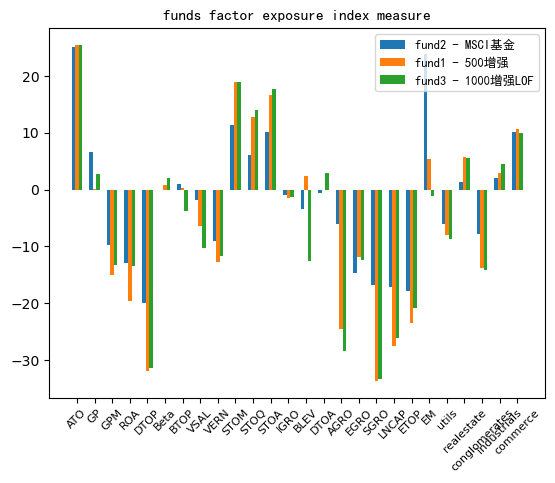

In [126]:
# See factor exposures
from matplotlib import font_manager
plt.rcParams['font.family']=['SimHei']

lm1 = linear_model.LinearRegression()
model = lm1.fit(factor_mat,myfund.loc[common_dt,'ret'])
lm2 = linear_model.LinearRegression()
model = lm2.fit(factor_mat,myfund2.loc[common_dt,'ret'])
lm3 = linear_model.LinearRegression()
model = lm3.fit(factor_mat,myfund3.loc[common_dt,'ret'])

X = factor_mat.columns
X_axis = np.arange(len(X))
plt.xticks(X_axis, X)
plt.bar(X_axis - 0.2, lm2.coef_, 0.2)
plt.bar(X_axis, lm1.coef_, 0.2)
plt.bar(X_axis + 0.2, lm3.coef_, 0.2)
plt.xticks(rotation=45,fontsize=8)


font = FontProperties(fname="SimHei.ttf", size=9) 
plt.legend(['fund2 - MSCI基金','fund1 - 500增强','fund3 - 1000增强LOF'],prop=font)
titlefont = FontProperties(fname="SimHei.ttf", size=11) 
plt.title('funds factor exposure index measure',font=titlefont)
